<a href="https://colab.research.google.com/github/simsekergun/ENEE691/blob/main/week12/CNN_Regression_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\color{ForestGreen}{\text{A CNN Model for Regression}}$

In [2]:
# Importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time

# Importing some basic modules in torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import BatchSampler, Dataset, DataLoader
from torch.utils.data import Subset

import torch
import torchvision
from torchvision import transforms

In [3]:


MNIST_train = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
MNIST_test = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

print('Size of MNIST train =', len(MNIST_train))
print('Size of MNIST test =', len(MNIST_test))

100%|██████████| 9912422/9912422 [00:00<00:00, 307455805.10it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 92399461.35it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 147942999.48it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16565677.19it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Size of MNIST train = 60000
Size of MNIST test = 10000


In [4]:
def moveTo(obj, device):
    if isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    elif hasattr(obj, "to"):
        return obj.to(device)
    else:
        return obj

In [5]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 

        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)
        
        y_hat = model(inputs) #this just computed f_Θ(x(i))

        # Compute loss.
        loss = loss_func(y_hat, labels)
         
        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )  # For regression 
        except:
            results[prefix + " " + name].append(score_func(y_true, np.argmax(y_pred, axis=1))) # For classification
    return end-start #time spent on epoch

In [6]:
def train_simple_network_alt(model, optimizer, loss_func, eta, train_loader, test_loader=None, score_funcs=None, 
                         epochs=50, device="cpu"):
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    if score_funcs is not None:
        for eval_score in score_funcs:
            to_track.append("train " + eval_score )
            if test_loader is not None:
                to_track.append("test " + eval_score )
        
    total_train_time = 0              #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
        
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(1, epochs+1), desc="Epoch"):
        model = model.train()#Put our model in training mode
        
        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, 
                                      prefix="train", desc="Training")  
        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )
        
        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", 
                          desc="Testing")
                
    return pd.DataFrame.from_dict(results)

In [7]:
percent_cap = 7

subset_train = Subset(MNIST_train, indices=range((len(MNIST_train)*percent_cap)//100))
subset_test = Subset(MNIST_test, indices=range((len(MNIST_test)*percent_cap)//100))

print('Number of samples in the train subset =', len(subset_train))
print('Number of samples in the test subset =', len(subset_test))

Number of samples in the train subset = 4200
Number of samples in the test subset = 700


In [8]:
# Constructing the new target variable through 'torch.sum()'

train_target_list = [torch.tensor([torch.sum(subset_train[i][0])]) for i in range(len(subset_train))]
test_target_list = [torch.tensor([torch.sum(subset_test[i][0])]) for i in range(len(subset_test))]
train_help_list = [[subset_train[i][0], subset_train[i][1]] for i in range(len(subset_train))]
test_help_list = [[subset_test[i][0], subset_test[i][1]] for i in range(len(subset_test))]

In [9]:
# Converting the image and new target into a list of tuples  

for i in range(len(subset_train)):
    train_help_list[i][1] = train_target_list[i]
    train_help_list[i] = tuple(train_help_list[i])
    
for i in range(len(subset_test)):
    test_help_list[i][1] = test_target_list[i]
    test_help_list[i] = tuple(test_help_list[i])

In [10]:
# Redefining the train and test data with the new (continuous) target

subset_train = train_help_list
subset_test = test_help_list

In [11]:
# Loading the data using 'DataLoader'

train_loader = DataLoader(subset_train, shuffle=True) 
test_loader = DataLoader(subset_test)

In [12]:
D = 28*28       # Number of features
n_target = 1    # Number of target variables
n_neuron = 256  # Number of neurons
eta = 0.001     # Learning rate

#del lin_reg_model

lin_reg_model = nn.Sequential(
    nn.Flatten(),                # Coverting tensors with structure (B, C, W, H) to (B,D)=(B, C*W*H)
    nn.Linear(D, n_neuron),
    nn.ReLU(),
    nn.Linear(n_neuron, n_target),
)

optimizer = torch.optim.Adam(lin_reg_model.parameters(), lr=eta)  # Adam optimizer

loss_func = nn.MSELoss()   # Loss function is MSE

In [13]:
# Training the model and collect the relevant performance metrics 

lin_reg_results = train_simple_network_alt(lin_reg_model, optimizer, loss_func, eta, train_loader, test_loader, 
                         score_funcs={'accuracy':r2_score}, epochs=10)

Training:  99%|█████████▉| 4154/4200 [00:07<00:00, 609.09it/s]
                                                              
Training:  99%|█████████▊| 4146/4200 [00:06<00:00, 657.27it/s]
                                                              
Training:  99%|█████████▉| 4173/4200 [00:08<00:00, 631.38it/s]
                                                              
Training:  99%|█████████▉| 4165/4200 [00:06<00:00, 419.47it/s]
                                                              
Training: 100%|█████████▉| 4180/4200 [00:06<00:00, 664.50it/s]
                                                              
Training:  99%|█████████▉| 4159/4200 [00:07<00:00, 621.20it/s]
                                                              
Training:  99%|█████████▊| 4139/4200 [00:06<00:00, 644.62it/s]
                                                              
Training:  99%|█████████▉| 4172/4200 [00:07<00:00, 595.46it/s]
                                                       

In [14]:
lin_reg_results

,epoch,total time,train loss,test loss,train accuracy,test accuracy
0,1,7.645769,134.076202,8.850680,0.875897,0.991322
1,2,14.245751,2.745902,1.942150,0.997458,0.998096
2,3,22.431488,2.281574,1.290960,0.997888,0.998734
3,4,29.496711,2.586347,0.881449,0.997606,0.999136
4,5,36.327317,1.834842,0.775583,0.998302,0.999240
5,6,43.570503,1.846411,1.559023,0.998291,0.998471
6,7,50.274190,1.676198,2.034187,0.998448,0.998005
7,8,57.731748,1.867291,0.840478,0.998272,0.999176
8,9,64.947762,1.435170,0.388285,0.998672,0.999619
9,10,72.174417,1.436594,1.840604,0.998670,0.998195


In [15]:
D = 28*28       # Number of features
n_target = 1    # Number of target variables
C = 1           # Number of channels
F = 2           # Number of filters
ker = 3         # Filter size
eta = 0.001     # Learning rate

#del cnn_reg_model

cnn_reg_model = nn.Sequential(
    nn.Conv2d(C, F, ker, padding=ker//2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(F*D, n_target),
)    

optimizer = torch.optim.Adam(cnn_reg_model.parameters(), lr=eta)  # Adam optimizer

loss_func = nn.MSELoss()   # Loss function is MSE

In [16]:
# Training the model and collect the relevant performance metrics 

cnn_reg_results = train_simple_network_alt(cnn_reg_model, optimizer, loss_func, eta, train_loader, test_loader, 
                         score_funcs={'accuracy':r2_score}, epochs=10)

Training:  97%|█████████▋| 4059/4200 [00:02<00:00, 1421.05it/s]
                                                               
Training:  99%|█████████▉| 4160/4200 [00:03<00:00, 1218.93it/s]
                                                               
Training: 100%|█████████▉| 4186/4200 [00:03<00:00, 1360.62it/s]
                                                               
Training:  97%|█████████▋| 4065/4200 [00:02<00:00, 1370.38it/s]
                                                               
Training:  98%|█████████▊| 4126/4200 [00:03<00:00, 1082.47it/s]
                                                               
Training: 100%|█████████▉| 4182/4200 [00:03<00:00, 1400.07it/s]
                                                               
Training: 100%|█████████▉| 4198/4200 [00:03<00:00, 1358.99it/s]
                                                               
Training:  99%|█████████▉| 4178/4200 [00:03<00:00, 1339.81it/s]
                                        

In [17]:
cnn_reg_results

,epoch,total time,train loss,test loss,train accuracy,test accuracy
0,1,3.101654,280.267183,1.660223,0.740580,0.998372
1,2,6.661521,0.473903,0.346351,0.999561,0.999660
2,3,9.751333,0.335358,0.379631,0.999690,0.999628
3,4,12.829974,0.328689,1.487027,0.999696,0.998542
4,5,16.272246,0.343288,0.079017,0.999682,0.999923
5,6,19.379715,0.314569,0.109784,0.999709,0.999892
6,7,22.483736,0.251987,0.564535,0.999767,0.999446
7,8,25.594052,0.291929,0.068861,0.999730,0.999932
8,9,29.117482,0.217430,0.626929,0.999799,0.999385
9,10,32.176661,0.260612,0.143217,0.999759,0.999860


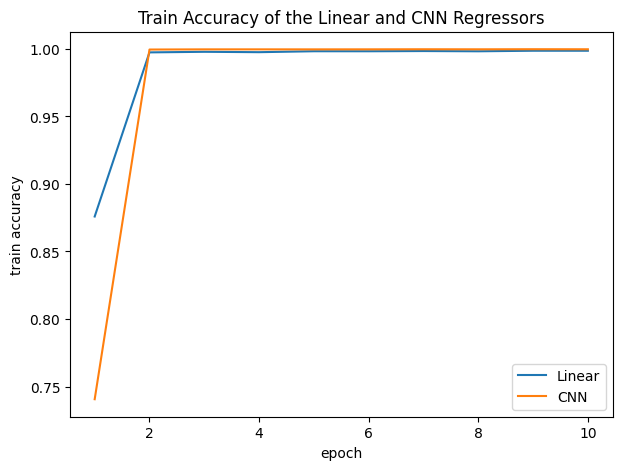

In [18]:
sns.lineplot(x='epoch', y='train accuracy', data=lin_reg_results, label='Linear')
sns.lineplot(x='epoch', y='train accuracy', data=cnn_reg_results, label='CNN')
plt.title('Train Accuracy of the Linear and CNN Regressors')
plt.gcf().set_size_inches(7, 5)
plt.show()

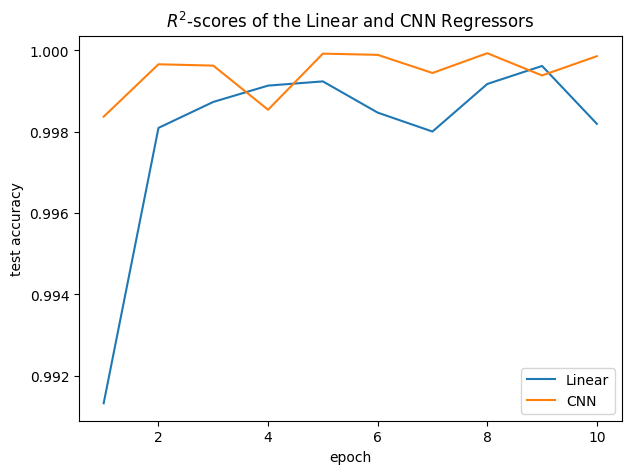

In [19]:
sns.lineplot(x='epoch', y='test accuracy', data=lin_reg_results, label='Linear')
sns.lineplot(x='epoch', y='test accuracy', data=cnn_reg_results, label='CNN')
plt.title(r'$R^2$-scores of the Linear and CNN Regressors')
plt.gcf().set_size_inches(7, 5)
plt.show()